In [1]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

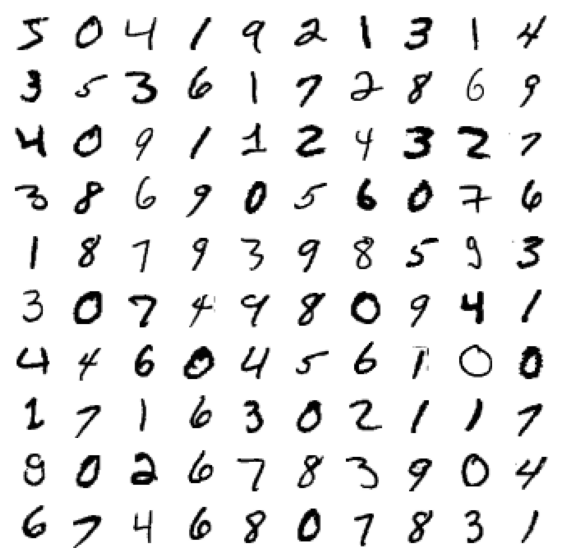

In [4]:
to_image = X[:100]
fig, axes = plt.subplots(10, 10, figsize=(7, 7))
for index, ax in enumerate(axes.flat):
    adjusted_image = to_image[index].reshape(28, 28)
    ax.imshow(adjusted_image, cmap='binary')
    ax.axis('off')

In [7]:
y_train_5, y_test_5 = (y_train==5), (y_test==5)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
some_digit = X_train[0]
sgd_clf.predict([some_digit])

array([ True])